# Исследование объявлений о продаже квартир

Предоставлены данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма.

Необходимо научиться определять рыночную стоимость объектов недвижимости. Задача — установить параметры. Это позволит построить автоматизированную систему, которая отследит аномалии и мошенническую деятельность. 


### Общая информация о данных

In [ ]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
# отключение предупреждений
pd.options.mode.chained_assignment = None 

In [ ]:
# чтение файла с данными
data = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv', sep = '\t')
data.head().T

,0,1,2,3,4
total_images,20,7,10,0,2
last_price,13000000.0,3350000.0,5196000.0,64900000.0,10000000.0
total_area,108.0,40.4,56.0,159.0,100.0
first_day_exposition,2019-03-07T00:00:00,2018-12-04T00:00:00,2015-08-20T00:00:00,2015-07-24T00:00:00,2018-06-19T00:00:00
rooms,3,1,2,3,2
ceiling_height,2.7,NaN,NaN,NaN,3.03
floors_total,16.0,11.0,5.0,14.0,14.0
living_area,51.0,18.6,34.3,NaN,32.0
floor,8,1,4,9,13
is_apartment,NaN,NaN,NaN,NaN,NaN


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [ ]:
print('Пропуски в данных')
data.isna().mean().sort_values(ascending=False)*100

Пропуски в данных


is_apartment            88.290645
parks_nearest           65.909954
ponds_nearest           61.559559
balcony                 48.605426
ceiling_height          38.799105
airports_nearest        23.384953
cityCenters_nearest     23.287902
ponds_around3000        23.283683
parks_around3000        23.283683
days_exposition         13.422507
kitchen_area             9.612220
living_area              8.029875
floors_total             0.362885
locality_name            0.206760
total_images             0.000000
last_price               0.000000
studio                   0.000000
floor                    0.000000
rooms                    0.000000
first_day_exposition     0.000000
total_area               0.000000
open_plan                0.000000
dtype: float64

В данных присутствуют пропуски - большая часть пропущенных значений в столбце с информацией о том, является ли данный вид недвижимости квартирой, далее пропуски присутствуют в информаци о ближайших парках, прудах, наличии балкона, высоте потолков и тд. Отсутствие данных можно объяснить рядом причин, основные из которых - отсутствие элемента, о котором спрашивают (балкон, парк, пруд и тд), очевидность ответа (является ли данный вид недвижимости квартирой), а также возможны нарушения в процедуре сбора информации, неверное хранение данных, либо уклонение от ответа владельцами недвижимости.

Также можно обратить внимание на не верный ормат данных в некоторых столбцах, данная проблеа будет устранена далее.

In [ ]:
data.shape

(23699, 22)

В данных присутствует 22 столбца и 23 699 строк со значениями

In [ ]:
# статистические данные
data.describe().T

,count,mean,std,min,25%,50%,75%,max
total_images,23699.0,9.858475e+00,5.682529e+00,0.0,6.00,9.00,14.0,50.0
last_price,23699.0,6.541549e+06,1.088701e+07,12190.0,3400000.00,4650000.00,6800000.0,763000000.0
total_area,23699.0,6.034865e+01,3.565408e+01,12.0,40.00,52.00,69.9,900.0
rooms,23699.0,2.070636e+00,1.078405e+00,0.0,1.00,2.00,3.0,19.0
ceiling_height,14504.0,2.771499e+00,1.261056e+00,1.0,2.52,2.65,2.8,100.0
floors_total,23613.0,1.067382e+01,6.597173e+00,1.0,5.00,9.00,16.0,60.0
living_area,21796.0,3.445785e+01,2.203045e+01,2.0,18.60,30.00,42.3,409.7
floor,23699.0,5.892358e+00,4.885249e+00,1.0,2.00,4.00,8.0,33.0
kitchen_area,21421.0,1.056981e+01,5.905438e+00,1.3,7.00,9.10,12.0,112.0
balcony,12180.0,1.150082e+00,1.071300e+00,0.0,0.00,1.00,2.0,5.0


**Вывод**
Таким образом, необходимо обработать пропуски в данных, исправить формат некоторых значений, устранить аномалии.

### Предобработка данных

#### Пропущенные значения

In [ ]:
# функция для потроения графика с информацией о пропущенных значениях

def pass_value_barh(df):
    (
        (df.isna().mean()*100)
        .to_frame()
        .rename(columns = {0:'space'})
        .query('space > 0')
        .sort_values(by = 'space', ascending = True)
        .plot(kind= 'barh', figsize=(19,6), rot = -5, legend = False, fontsize = 16, color ='tab:purple', grid = True) 
        .set_title('Распределение пропущенных значений в данных' + "\n", fontsize = 22, color = 'xkcd:very dark purple') 
          
    );    

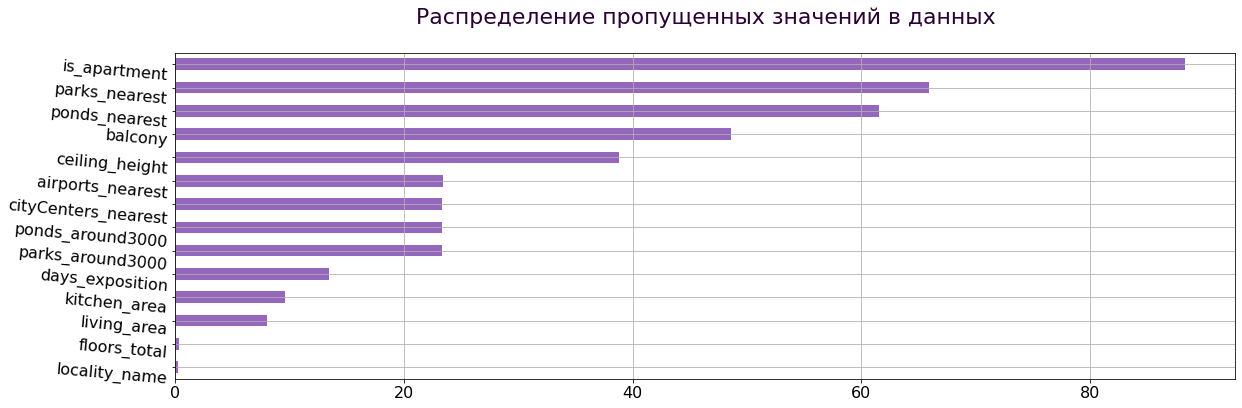

In [ ]:
# применение функции
pass_value_barh(data)

In [ ]:
#заменим пропуски в столбце balcony на 0
data.balcony = data.balcony.fillna(0)


Причины по которым могли появиться пропуски в данных:

1) Небрежность при заполнении 

2) Отсутствие какого-либо элемента - пример: отсутсвие балкона (водоёмов, парков, аэропорта и тп)

3) Данные не верно выгрузились или сохранились, либо не были обязательными для выгрузки (анамально высокое количество пропусков в "is_apartment", странно также отсутсвие населенного пункта в некоторых строках в столбце "locality_name")

#### Изменение типа данных

In [ ]:
# изменение формата данных
data.last_price = data.last_price.apply(int)
data.balcony = data.balcony.apply(int)
data['floors_total']=data['floors_total'].astype('Int64')
data.first_day_exposition = pd.to_datetime(data['first_day_exposition'], format = '%Y-%m-%dT%H:%M:%S')

В столбцах "last_price", "rooms", "floors_total", "balcony", "days_exposition" - очевидно находятся данные с целыми числами, однако из-за пропусков в данных не все из них удалось сразу перевести в тип "int". Сначала неизвестные значения были переведены в тип 'str' и затем иcключены из отбора, который перевел 'float' в 'int'

В столбце "first_day_exposition" находится дата, которая была переведена в соответствующий формат

In [ ]:
# проверка форматов данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  int64         
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        14504 non-null  float64       
 6   floors_total          23613 non-null  Int64         
 7   living_area           21796 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          2775 non-null   object        
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          21421 non-null  float64       
 13  balcony         

#### Устранение неявных дубликатов

In [ ]:
# устранение неявных дубликатов в "locality_name" - названиях населенных пунктов
print('Количество уникальных значений в столбце locality_name -', data['locality_name'].nunique())
print(data ['locality_name'].sort_values().unique())


Количество уникальных значений в столбце locality_name - 364
['Бокситогорск' 'Волосово' 'Волхов' 'Всеволожск' 'Выборг' 'Высоцк'
 'Гатчина' 'Зеленогорск' 'Ивангород' 'Каменногорск' 'Кингисепп' 'Кириши'
 'Кировск' 'Колпино' 'Коммунар' 'Красное Село' 'Кронштадт' 'Кудрово'
 'Лодейное Поле' 'Ломоносов' 'Луга' 'Любань' 'Мурино' 'Никольское'
 'Новая Ладога' 'Отрадное' 'Павловск' 'Петергоф' 'Пикалёво' 'Подпорожье'
 'Приморск' 'Приозерск' 'Пушкин' 'Санкт-Петербург' 'Светогорск'
 'Сертолово' 'Сестрорецк' 'Сланцы' 'Сосновый Бор' 'Сясьстрой' 'Тихвин'
 'Тосно' 'Шлиссельбург' 'городской поселок Большая Ижора'
 'городской поселок Янино-1' 'городской посёлок Будогощь'
 'городской посёлок Виллози' 'городской посёлок Лесогорский'
 'городской посёлок Мга' 'городской посёлок Назия'
 'городской посёлок Новоселье' 'городской посёлок Павлово'
 'городской посёлок Рощино' 'городской посёлок Свирьстрой'
 'городской посёлок Советский' 'городской посёлок Фёдоровское'
 'городской посёлок Янино-1' 'деревня Агалатов

In [ ]:
# слова переведены в аббревиатуры, "е" исправлена на "ё"
data ['locality_name2'] = data ['locality_name'].str.replace('поселок', 'посёлок')\
                                                .str.replace('посёлок городского типа', 'ПГТ')\
                                                .str.replace('городской посёлок', 'ПГТ')\
                                                .str.replace('садовое товарищество', 'СНТ')\
                                                .str.replace('садоводческое некоммерческое товарищество', 'СНТ')\
                                                .str.replace('посёлок станции', 'посёлок при железнодорожной станции')\
                                                .str.replace('посёлок Рябово', 'ПГТ Рябово')

In [ ]:
# 364 уникальных значения были сокращены до 320
print('Изначальное количество уникальных значений в столбце locality_name -', data['locality_name'].nunique())
print('Обновленное количество уникальных значений в столбце locality_name -', data['locality_name2'].nunique())


Изначальное количество уникальных значений в столбце locality_name - 364
Обновленное количество уникальных значений в столбце locality_name - 320


In [ ]:
# устранение неявных дубликатов в "rooms" - удаление строк со значнием комнат больше 8
data.pivot_table(index='rooms', values = 'total_images', aggfunc='count')\
    .rename(columns={'total_images':'number_of_expositions'})\
    .sort_values(by='number_of_expositions', ascending=False)

,number_of_expositions
rooms,
1,8047
2,7940
3,5814
4,1180
5,326
0,197
6,105
7,59
8,12


In [ ]:
# удаление количества комнат превышающее 8
data = data.query ('rooms < 8.0')

In [ ]:
# сбор уникальных данных для анализа высот потолков
data.pivot_table(index='ceiling_height', values = 'total_images', aggfunc='count')\
    .rename(columns={'total_images':'number of expositions'})\
    .sort_values(by='number of expositions', ascending=False)

,number of expositions
ceiling_height,
2.50,3514
2.60,1646
2.70,1574
3.00,1109
2.80,992
...,...
3.88,1
3.93,1
3.98,1


In [ ]:
# удаление значений высот потолков свыше 6 метров и ниже 2.5 метров (не стала заменять значения 32 на 3.2 и тп, так как нет полной уверенности 
# в точности этих действий, что может исказить результат исследования)
data = data [(data.ceiling_height<=6)|(data['ceiling_height'].isna())]
data = data[(data.ceiling_height>=2.5)|(data['ceiling_height'].isna())]

In [ ]:
data.isna().mean().sort_values(ascending=False)*100

is_apartment            88.334889
parks_nearest           65.976407
ponds_nearest           61.546296
ceiling_height          38.979886
airports_nearest        23.342952
cityCenters_nearest     23.245353
ponds_around3000        23.241110
parks_around3000        23.241110
days_exposition         13.400662
kitchen_area             9.594331
living_area              8.045489
floors_total             0.364933
locality_name2           0.207927
locality_name            0.207927
total_images             0.000000
balcony                  0.000000
last_price               0.000000
studio                   0.000000
floor                    0.000000
rooms                    0.000000
first_day_exposition     0.000000
total_area               0.000000
open_plan                0.000000
dtype: float64

В данных было обнаружено:

Число комнат достигает значения - 19, были изъяты данные с числом комнат от 8 до 19 (тк они имеют малые значения и не исказят результат после удаления)

Высоты потолка имеют анамально большие значения, поэтому были удалены строки со значениями свыше 6 метров и менее 2.5 метров (не стала заменять значения 32 на 3.2 и тп, так как нет полной уверенности в точности этих действий, что это не исказит результат исследования)



Количество комнат равное 0 кажется аномальным, но возможно это квартира студия или тп и там нет деления на комнаты

In [ ]:
# сводная таблица по ценам и количеству предложений
price_df = data.last_price.value_counts().to_frame()\
               .reset_index()\
               .rename(columns={'index':'Price','last_price':'Number of expositions'})\
               .sort_values(by='Price')
price_df.head()

,Price,Number of expositions
2904,12190,1
1073,430000,2
1172,440000,1
547,450000,4
631,470000,3


In [ ]:
# удаление строки со значенем цены 12 190 руб, так как слишком мало для значения цены
data = data[(data.last_price>13000)|(data['last_price'].isna())]

In [ ]:
# максимальне количество этажей в домах найдено - 36 (реальные объявления на настоящий момент), поэтому были удалены значения свыше
display(data.floors_total.value_counts().to_frame().reset_index().sort_values(by='index').tail())
data = data [(data.floors_total<=37)|(data['floors_total'].isna())]


,index,floors_total
30,34,1
26,35,24
29,36,2
34,52,1
31,60,1


In [ ]:
# Показатели о кол-ве объявлений в датасете, минимальных и максимальных показателях 
# в выбранных параметрах о продаже квартир
(
    data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  'kitchen_area', 'floor',
       'floors_total']]
    .apply (['count', 'min', 'max'])   
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
count,"23,563.00","23,563.00","14,377.00","20,405.00","23,563.00","21,667.00","21,302.00","23,563.00","23,477.00"
min,0.00,12.00,2.50,1.00,"430,000.00",2.00,1.30,1.00,1.00
max,7.00,631.20,6.00,"1,580.00","763,000,000.00",347.50,107.00,33.00,36.00


Итого после обрабоки были исправлены следующие данные:
* количество комнат уменьшено до 7
* высота потолков уменьшена до диапазона от 2.5 до 6 метров
* удалена аномально минимальная цена (12 190 руб.)
* количество этажей в доме уменьшено до разумных пределов - 36 этажей

### Добавление в таблицу новых столбцов

In [ ]:
# цена одного квадратного метра
data ['price_per_metre'] = (data['last_price'] / data['total_area']).round(2)
data ['price_in_mln'] = data['last_price'] / 1000000
# процент жилой площади от общей площади
data['per_of_liv'] = data['living_area']/data['total_area']*100

In [ ]:
# тип этажа квартиры (значения — «первый», «последний», «другой»)
data.loc[data['floor'] == 1, 'type_of_floor'] = 'первый'
data.loc[data['floor'] == data['floors_total'], 'type_of_floor'] = 'последний'
data.loc[data['type_of_floor'].isna(), 'type_of_floor'] = 'другой'

In [ ]:
# расстояние до центра города в километрах (переведите из м в км и округлите до целых значений)
data ['cityCenters_per_km'] = (data['cityCenters_nearest'] / 1000).apply(np.ceil)

In [ ]:
# день недели публикации объявления (0 — понедельник, 1 — вторник и так далее)
data ['weekday_of_exposition'] = data['first_day_exposition'].dt.weekday
data ['weekday_of_exposition'].value_counts()

3    4268
1    4160
4    3983
2    3949
0    3587
5    1930
6    1686
Name: weekday_of_exposition, dtype: int64

In [ ]:
# функция для редактирования дней недели
def func_for_weekday_3(df):
    day = df['weekday_of_exposition']
    
    if day==0:
        return 'пн'
    if day==1:
        return 'вт'
    if day==2:
        return 'ср'
    if day==3:
        return 'чт'
    if day==4:
        return 'пт'
    if day==5:
        return 'сб'
    if day==6:
        return 'вс'
    if day==np.nan:
        return 'неизвестен'
    
data ['weekday_of_exposition_3']=data.apply(func_for_weekday_3,axis=1)

data [['weekday_of_exposition_3','weekday_of_exposition']].value_counts().to_frame()


,,0
weekday_of_exposition_3,weekday_of_exposition,
чт,3,4268
вт,1,4160
пт,4,3983
ср,2,3949
пн,0,3587
сб,5,1930
вс,6,1686


In [ ]:
# месяц публикации объявления
data ['month_of_exposition'] = data['first_day_exposition'].dt.month
# год публикации объявления
data ['year_of_exposition'] = data['first_day_exposition'].dt.year

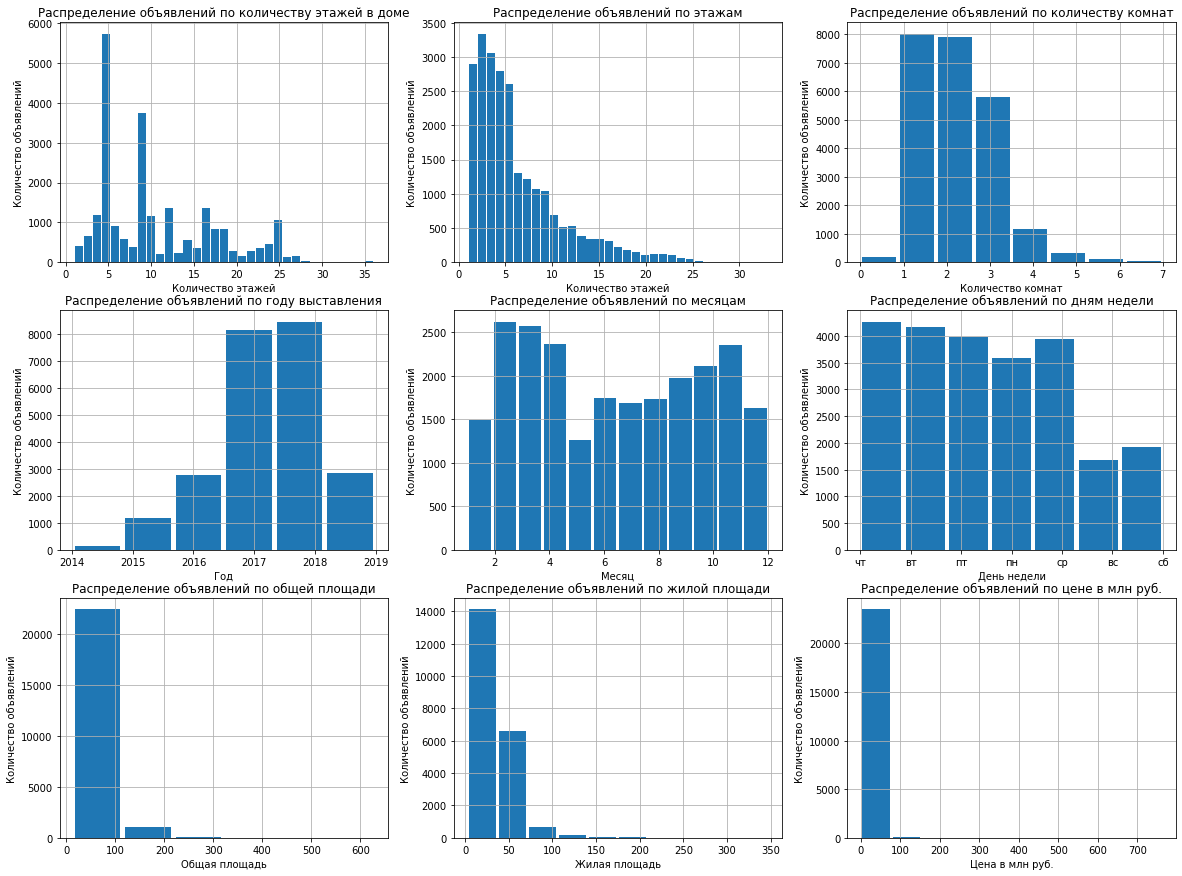

In [ ]:
fig, ax = plt.subplots(3,3, figsize=(20,15))

ax[0,0].hist(data.floors_total.dropna(), rwidth = 0.9,bins=data.floors_total.nunique())
ax[0,0].set_title('Распределение объявлений по количеству этажей в доме')
ax[0,0].set_xlabel('Количество этажей')
ax[0,0].grid()
ax[0,0].set_ylabel('Количество объявлений')

ax[0,1].hist(data.floor.dropna(), rwidth = 0.9,bins=data.floor.nunique())
ax[0,1].set_title('Распределение объявлений по этажам')
ax[0,1].set_xlabel('Количество этажей')
ax[0,1].grid()
ax[0,1].set_ylabel('Количество объявлений');

ax[0,2].hist(data.rooms.dropna(), rwidth = 0.9,bins=data.rooms.nunique())
ax[0,2].set_title('Распределение объявлений по количеству комнат')
ax[0,2].set_xlabel('Количество комнат')
ax[0,2].grid()
ax[0,2].set_ylabel('Количество объявлений');

ax[1,0].hist(data.year_of_exposition.dropna(), rwidth = 0.9,bins=data.year_of_exposition.nunique())
ax[1,0].set_title('Распределение объявлений по году выставления')
ax[1,0].set_xlabel('Год')
ax[1,0].grid()
ax[1,0].set_ylabel('Количество объявлений')

ax[1,1].hist(data.month_of_exposition.dropna(), rwidth = 0.9,bins=data.month_of_exposition.nunique())
ax[1,1].set_title('Распределение объявлений по месяцам')
ax[1,1].set_xlabel('Месяц')
ax[1,1].grid()
ax[1,1].set_ylabel('Количество объявлений');

ax[1,2].hist(data.weekday_of_exposition_3.dropna(), rwidth = 0.9,bins=data.weekday_of_exposition_3.nunique())
ax[1,2].set_title('Распределение объявлений по дням недели')
ax[1,2].set_xlabel('День недели')
ax[1,2].grid()
ax[1,2].set_ylabel('Количество объявлений');

ax[2,0].hist(data.total_area.dropna(), rwidth = 0.9,bins=6)
ax[2,0].set_title('Распределение объявлений по общей площади')
ax[2,0].set_xlabel('Общая площадь')
ax[2,0].grid()
ax[2,0].set_ylabel('Количество объявлений')

ax[2,1].hist(data.living_area.dropna(), rwidth = 0.9,bins=10)
ax[2,1].set_title('Распределение объявлений по жилой площади')
ax[2,1].set_xlabel('Жилая площадь')
ax[2,1].grid()
ax[2,1].set_ylabel('Количество объявлений');

ax[2,2].hist(data.price_in_mln.dropna(), rwidth = 0.9,bins=10)
ax[2,2].set_title('Распределение объявлений по цене в млн руб.')
ax[2,2].set_xlabel('Цена в млн руб.')
ax[2,2].grid()
ax[2,2].set_ylabel('Количество объявлений');


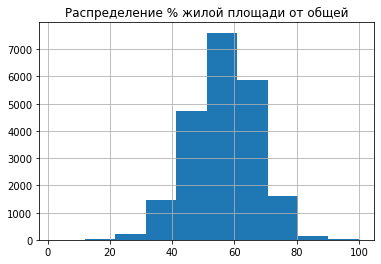

In [ ]:
# построение графика рапределения жилой площади от общей 
plt.hist(data.per_of_liv,bins = 10)
plt.title('Распределение % жилой площади от общей')
plt.grid()
plt.rcParams["figure.figsize"] = [9, 4]
plt.show()

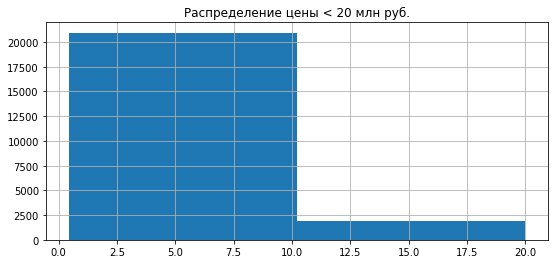

In [ ]:
# построение графика рапределения цены < 20 млн руб. 
plt.hist(data[data['price_in_mln']<20]['price_in_mln'],bins = 2)
plt.title('Распределение цены < 20 млн руб.')
plt.grid()
plt.rcParams["figure.figsize"] = [9, 4]
plt.show()

Из данных графиков можно сделать следующие выводы по 23 563 объявлениям:

* большинство объявлений о продаже недвижимости в 5этажных домах (более 5,5 тыс.), далее по популярности идут 9 этажные дома (чуть менее 4 тыс объявлений), остальные распределены в количестве менее 1.5 тыс 
* распределение объявлений по этажам имеет нормальный вид, основной объем - с 1 по 5 этаж, далее количество объявлений по этажам идет на убыль
* 1комнатные и 2комнатные квартиры составляют по 8 тыс объявлений каждая, далее по популярности располагаются 3комнатные квартиры (почти 6 тыс объявлений), остальные варианты - менее 1.5 тыс
* касательно даты размещения объявлений - большая часть обявлений была размещена в 2017-2018 годах (по 8 тыс объявлений), в 2019 году пока 3 тыс объявлений, так как год проведения исследования еще не закончен. Наиболее популярными месяцами для размещения объявлений являются февраль, март, апрель, ноябрь, но данные пиковые значения расходятся с остальными месяцами всего на 1000-500 шт. Также можно сделать вывод, что наиболее популярными днями недели для вставления объявлений являются будние дни
* говоря об общей площади жилья - 20 тыс объявлений (84% от общего числа) составляет менее 100 м2, распредление жилой площади от общей имеет нормальное распредление - пиковые значения от 50 до 70%
* распределение цен - большая часть объявлений с ценой менее 50 млн руб., 20 тыс объявлений (84%) с ценой менее 10 млн руб.

#### Изучение количества дней до продажи квартиры (столбец days_exposition)

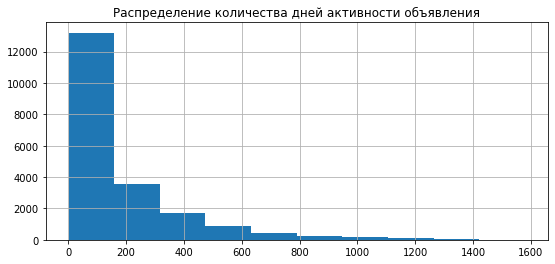

In [ ]:
# построение графика рапределения цены < 20 млн руб. 
plt.hist(data['days_exposition'])
plt.title('Распределение количества дней активности объявления')
plt.grid()
plt.rcParams["figure.figsize"] = [9, 4]
plt.show()

In [ ]:
data.days_exposition.describe()

count    20405.000000
mean       180.783778
std        219.639202
min          1.000000
25%         45.000000
50%         95.000000
75%        231.000000
max       1580.000000
Name: days_exposition, dtype: float64

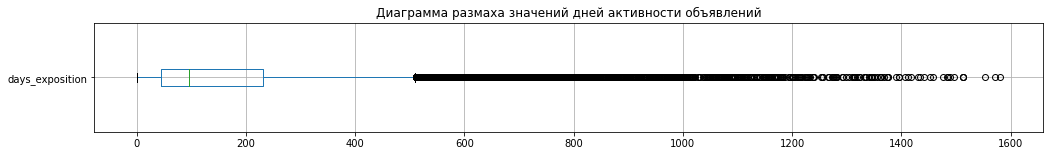

In [ ]:
fig, ax = plt.subplots(figsize = (17,2))
ax = data[['days_exposition']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений дней активности объявлений');


Среднее количество дней продажи квартир - 180

95 дней - значение, находящееся посередине выборки

Быстрые продажи - до 45 дней, долгие - 200 дней.

* Максимальное значение достигло 4 лет
* Минимальное - 1 день

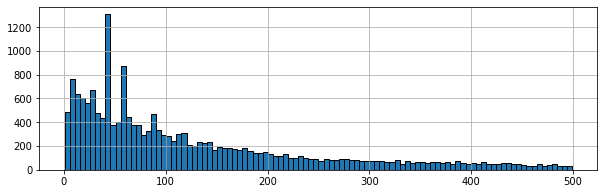

In [ ]:
data.query('days_exposition<500')['days_exposition'].hist(bins=100, figsize=(10,3), ec='black');

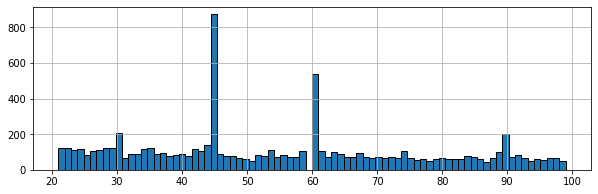

In [ ]:
data.query('20<days_exposition<100')['days_exposition'].hist(bins=80, figsize=(10,3), ec='black');

Наблюдаются пики значений на 30, 45, 60, 90 день. 
Выявлено, что по условиям платформы бесплатные объявления закрываются после истечения определенного срока.  
Сроки бесплатного размещения объявления для квартир стоимостью:
* до 4,5 млн — 45 дней
* от 4,5 до 10 млн — 60 дней
* от 10 млн — 90 дней
* Арендные объявления 7 и 30 дней

#### Факторы влияния на стоимость недвижимости

##### Зависимость цены от общей площади

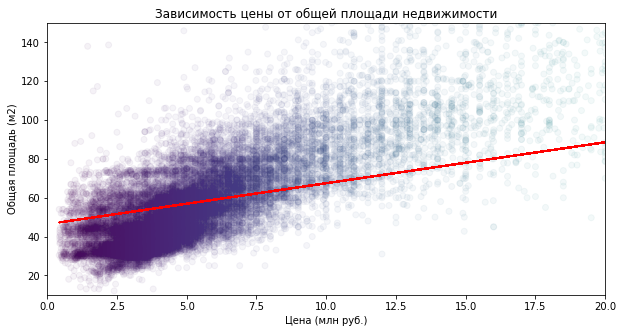

In [ ]:
fig, ax = plt.subplots()

y=data['total_area']
x=data['price_in_mln']

ax.scatter(x,y,c=x,vmin=0, vmax=40, alpha=0.05)

fig.set_figwidth(10)   
fig.set_figheight(5)  

ax.set_ylim([10, 150])
ax.set_xlim([0, 20])

z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r-")

ax.set_title('Зависимость цены от общей площади недвижимости')
ax.set_xlabel('Цена (млн руб.)')
ax.set_ylabel('Общая площадь (м2)')

plt.show()

На данном графике можно наблюдать прямую зависимость - чем больше общая площадь недвижимости, тем больше цена

##### Зависимость цены от жилой площади

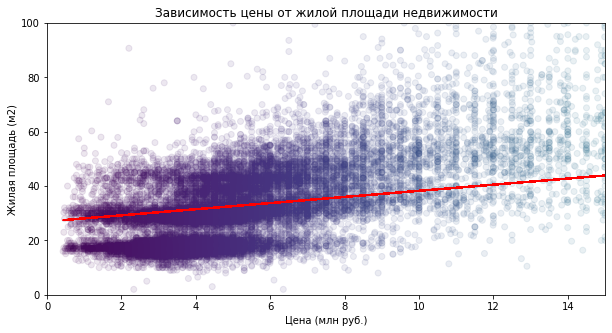

In [ ]:
# 

fig, ax = plt.subplots()

data_poly = data.dropna(subset=['living_area']).copy()

y=data_poly['living_area']
x=data_poly['price_in_mln']

ax.scatter(x,y,c=x,vmin=0, vmax=40, alpha=0.1)

fig.set_figwidth(10)   
fig.set_figheight(5)  

ax.set_ylim([0, 100])
ax.set_xlim([0, 15])

z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r-")


ax.set_title('Зависимость цены от жилой площади недвижимости')
ax.set_xlabel('Цена (млн руб.)')
ax.set_ylabel('Жилая площадь (м2)')

plt.show()

На данном графике можно наблюдать прямую зависимость - чем больше жилая площадь недвижимости, тем больше цена

##### Зависимость цены от площади кухни

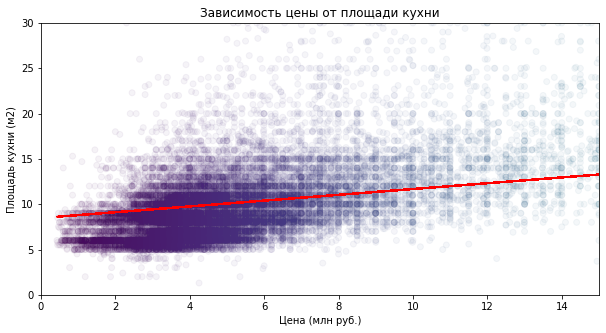

In [ ]:
fig, ax = plt.subplots()

data_poly = data.dropna(subset=['kitchen_area']).copy()

y=data_poly['kitchen_area']
x=data_poly['price_in_mln']

ax.scatter(x,y,c=x,vmin=0, vmax=40, alpha=0.05)

fig.set_figwidth(10)   
fig.set_figheight(5)  

ax.set_ylim([0, 30])
ax.set_xlim([0, 15])

z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r-")

ax.set_title('Зависимость цены от площади кухни')
ax.set_xlabel('Цена (млн руб.)')
ax.set_ylabel("Площадь кухни (м2)")

plt.show()

На графиках зависимости цены от площади кухни также наблюдается прямая зависимость

##### Зависимость цены от количества комнат

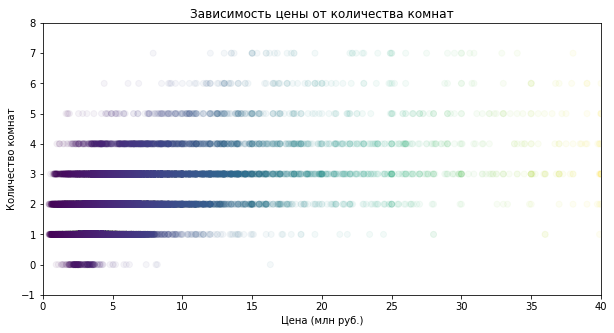

In [ ]:
fig, ax = plt.subplots()

y=data['rooms']
x=data['price_in_mln']

ax.scatter(x,y,c=x,vmin=0, vmax=40, alpha=0.05)

fig.set_figwidth(10)   
fig.set_figheight(5)  

ax.set_ylim([-1, 8])
ax.set_xlim([0, 40])

ax.set_title('Зависимость цены от количества комнат')
ax.set_xlabel('Цена (млн руб.)')
ax.set_ylabel("Количество комнат")

plt.show()

Чем больше комнат, тем выше цена

##### Зависимость цены от типа этажа

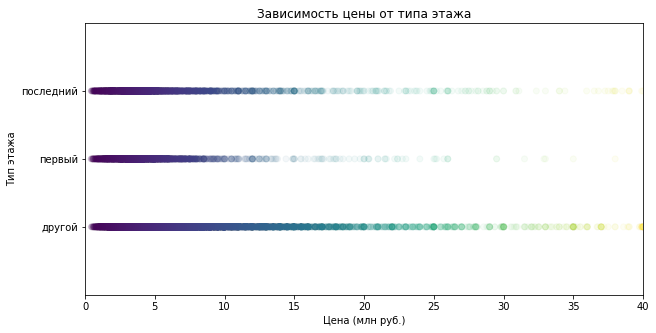

In [ ]:
fig, ax = plt.subplots()

y=data['type_of_floor']
x=data['price_in_mln']

ax.scatter(x,y,c=x,vmin=0, vmax=40, alpha=0.05)

fig.set_figwidth(10)   
fig.set_figheight(5)  

ax.set_ylim([-1, 3])
ax.set_xlim([0, 40])

ax.set_title('Зависимость цены от типа этажа')
ax.set_xlabel('Цена (млн руб.)')
ax.set_ylabel("Тип этажа")

plt.show()


Зависимость от типа этажа - недвижимость на первом этаже стоит дешевле, большая цена и количество объявлений - это недвижимость между первым и последним этажами, количество комнат - чем больше комнат, тем больше стоимость (увеличение площади)

##### Зависимость цены даты размещения объявления

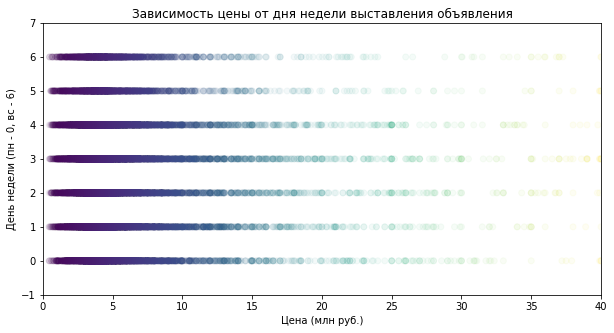

In [ ]:
fig, ax = plt.subplots()

y=data['weekday_of_exposition']
x=data['price_in_mln']

ax.scatter(x,y,c=x,vmin=0, vmax=40, alpha=0.05)

fig.set_figwidth(10)   
fig.set_figheight(5)  

ax.set_ylim([-1, 7])
ax.set_xlim([0, 40])

ax.set_title('Зависимость цены от дня недели выставления объявления')
ax.set_xlabel('Цена (млн руб.)')
ax.set_ylabel("День недели (пн - 0, вс - 6)")

plt.show()

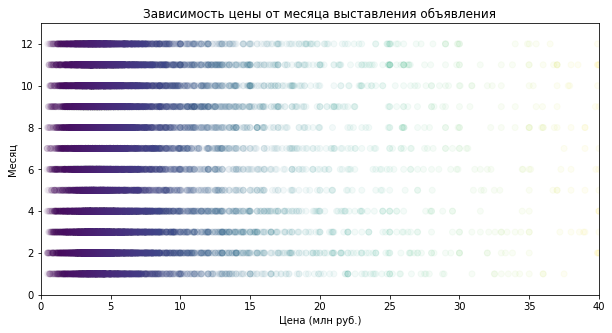

In [ ]:
fig, ax = plt.subplots()

y=data['month_of_exposition']
x=data['price_in_mln']

ax.scatter(x,y,c=x,vmin=0, vmax=40, alpha=0.05)

fig.set_figwidth(10)   
fig.set_figheight(5)  

ax.set_ylim([0,13])
ax.set_xlim([0, 40])

ax.set_title('Зависимость цены от месяца выставления объявления')
ax.set_xlabel('Цена (млн руб.)')
ax.set_ylabel("Месяц")

plt.show()

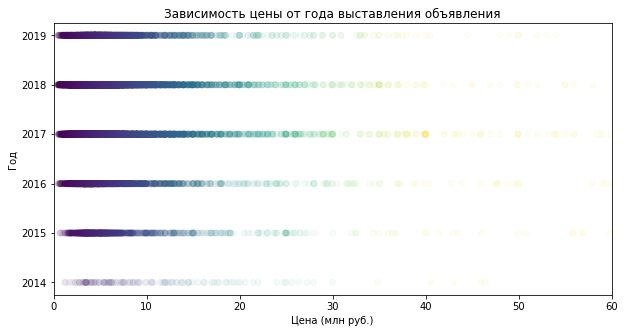

In [ ]:
fig, ax = plt.subplots()

y=data['year_of_exposition']
x=data['price_in_mln']

ax.scatter(x,y,c=x,vmin=0, vmax=40, alpha=0.05)

fig.set_figwidth(10)   
fig.set_figheight(5)  

#ax.set_ylim([2013,2020])
ax.set_xlim([0, 60])

ax.set_title('Зависимость цены от года выставления объявления')
ax.set_xlabel('Цена (млн руб.)')
ax.set_ylabel("Год")

plt.show()

По году выставления объявления видно, что их количество растет с каждым годом, при этом увеличивается и максимальная цена недвижимости. В 2019 году значений не так много, так как год в момент исследования еще не закончился, однако наблюдается положительная тенденция роста цен.
Зависимость между ценой и днем недели и месяцем выставления объявления оценить нет возможности.

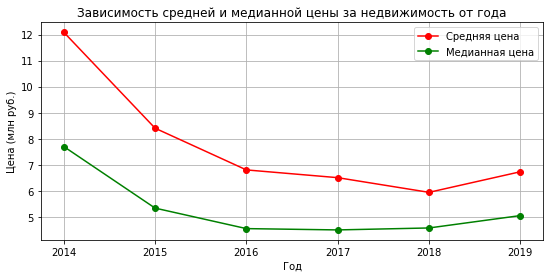

In [ ]:
df=pd.pivot_table(data,index='year_of_exposition', values='price_in_mln',aggfunc='mean').reset_index()
df2=pd.pivot_table(data,index='year_of_exposition', values='price_in_mln',aggfunc='median').reset_index()
df3=pd.pivot_table(data,index='year_of_exposition', values='price_in_mln',aggfunc='max').reset_index()
df4=pd.pivot_table(data,index='year_of_exposition', values='price_in_mln',aggfunc='min').reset_index()

fig, ax = plt.subplots()
ax.plot(df['year_of_exposition'], df['price_in_mln'],'r-o', label='Средняя цена');
ax.plot(df2['year_of_exposition'], df2['price_in_mln'],'g-o', label='Медианная цена');

ax.grid()
plt.legend()

ax.set_xlabel('Год');
ax.set_ylabel('Цена (млн руб.)');
ax.set_title('Зависимость средней и медианной цены за недвижимость от года');


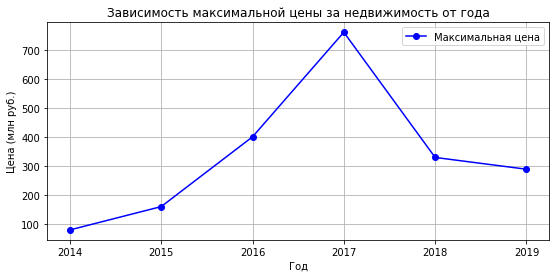

In [ ]:
fig, ax = plt.subplots()
ax.plot(df3['year_of_exposition'], df3['price_in_mln'],'b-o', label='Максимальная цена');
ax.grid()
plt.legend()

ax.set_xlabel('Год');
ax.set_ylabel('Цена (млн руб.)');
ax.set_title('Зависимость максимальной цены за недвижимость от года');


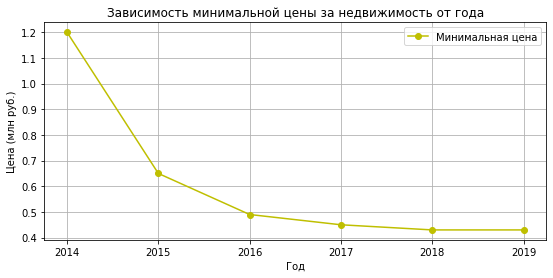

In [ ]:
fig, ax = plt.subplots()
ax.plot(df4['year_of_exposition'], df4['price_in_mln'],'y-o', label='Минимальная цена');
ax.grid()
plt.legend()

ax.set_xlabel('Год');
ax.set_ylabel('Цена (млн руб.)');
ax.set_title('Зависимость минимальной цены за недвижимость от года');

После подсчета среднего и медианного значения цены за каждый год видно, что с 2014 года оно снижалось, однако в 2019 наблюдается подъем, но мы не можем брать это значение в рассчет, так как год еще не закончен. В 2017 году виден пик максимальной цены, после чего она пошла на спад, минимальная цена достигла своего пика в 2014 году, после чего также пошла на спад.

##### Рассчет коэффициента корреляции для основных параметров

In [ ]:
corr_data=data[['price_in_mln', 'total_area','living_area','kitchen_area','rooms','floor','type_of_floor']]

In [ ]:
corr_data.corr().round(2).price_in_mln.to_frame()

,price_in_mln
price_in_mln,1.00
total_area,0.64
living_area,0.55
kitchen_area,0.51
rooms,0.35
floor,0.02


Вывод по зависимости разных показателей от стоимости недвижимости:

Как видно из значений корреляции - наибольший коэффициент у общей площади (0.64), это значит, что чем больше площадь, тем больше стоимость недвижимости, далее идут жилая площадь и площадь кухни (0.55 и 0.51 соответственно). Количество комнат не значительно влияет на цену (0.35). Этаж - недвижимость на первом этаже стоит дешевле, большая цена и количество объявлений - это недвижимость между первым и последним этажами, день недели и месяц выставления публикации имеют нелинейную зависимость от цены, а год выставления публикации при сравнении со средним и медианным значениями цены показывает, что с 2014 года эти значения снижались, однако в 2019 наблюдается подъем, но мы не можем брать это значение в рассчет, так как год еще не закончен.

#### Населённые пункты с самой высокой и низкой стоимостью квадратного метра

In [ ]:
data_pivot=data.pivot_table(index=['locality_name'], values=['total_images','price_per_metre'],\
                            aggfunc={'total_images':'count','price_per_metre':'mean'})
data_pivot=data_pivot.rename(columns={'price_per_metre':'mean_price_per_metre', 'total_images':'number_of_expositions' })
top10=data_pivot.sort_values(by='number_of_expositions',ascending=False).head(10).round(2)
top10=top10.sort_values(by='mean_price_per_metre',ascending=True)
top10


,mean_price_per_metre,number_of_expositions
locality_name,,
Выборг,58238.14,235
Всеволожск,68719.32,397
Гатчина,68757.68,306
Колпино,75352.48,336
посёлок Шушары,78677.36,440
посёлок Мурино,85725.24,520
посёлок Парголово,90205.42,326
деревня Кудрово,92473.55,299
Пушкин,103147.83,366


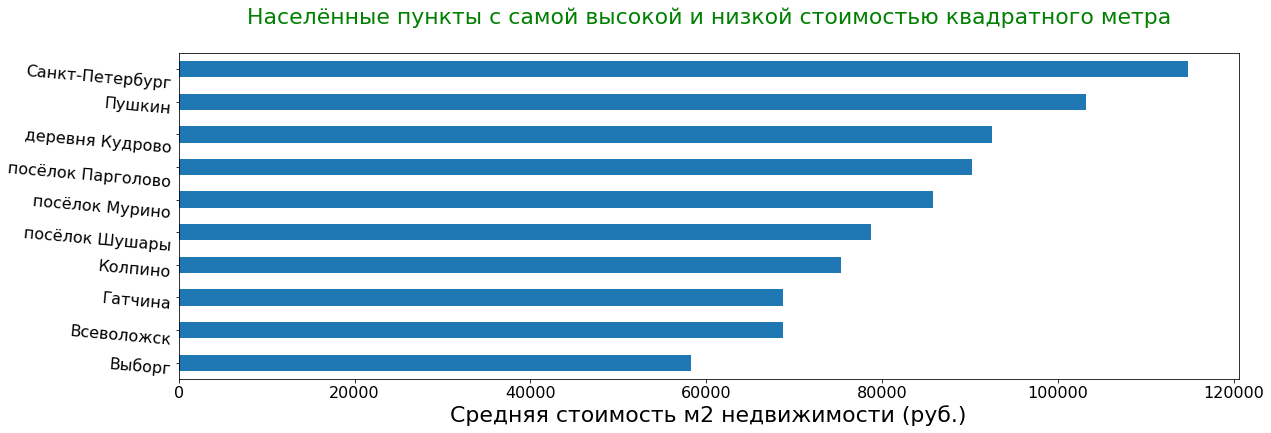

In [ ]:
top10=top10[['mean_price_per_metre']]
ax=top10.plot(kind= 'barh', figsize=(19,6), rot = -5, legend = False, fontsize = 16);
ax.set_title('Населённые пункты с самой высокой и низкой стоимостью квадратного метра' + "\n",\
           fontsize = 22, color = 'Green');
ax.set_ylabel('');
ax.set_xlabel('Средняя стоимость м2 недвижимости (руб.)', fontsize = 22);

In [ ]:
data_pivot.sort_values(by='mean_price_per_metre',ascending=False).round(2)

,mean_price_per_metre,number_of_expositions
locality_name,,
посёлок Лисий Нос,121616.22,2
Зеленогорск,115122.80,24
Санкт-Петербург,114800.30,15639
посёлок Репино,104238.61,4
Пушкин,103147.83,366
...,...,...
поселок Совхозный,12629.13,2
деревня Выскатка,12335.48,2
деревня Вахнова Кара,11688.31,1


Вывод:

Из 10 населенных пунктов с самым большим числом объявлений наибольшая средняя цена за м2 в Санкт-Петербурге (114 764.28 руб.), а самая наименьшая в Выборге (58 141.91 руб.)

А если рассматривать все данные - наибольшая цена за м2 в посёлке Лисий Нос (121 616.22 руб.), а наименьшая в деревне Старополье (11 206.22 руб.)		

#### Оценка зависимости цены недвижимости от расстояния до центра города

In [ ]:
cityCenters_pivot=data.query('locality_name =="Санкт-Петербург"')

cityCenters_pivot['cityCenters_per_km']=cityCenters_pivot['cityCenters_per_km'].apply(np.ceil)
cityCenters_pivot=cityCenters_pivot.pivot_table(index='cityCenters_per_km',values='price_in_mln',aggfunc='mean').reset_index()
cityCenters_pivot.sort_values(by='price_in_mln', ascending=False)


,cityCenters_per_km,price_in_mln
0,1.0,23.442315
1,2.0,18.719976
2,3.0,15.879863
5,6.0,15.113658
6,7.0,14.389106
4,5.0,13.526829
3,4.0,13.102738
7,8.0,11.630431
8,9.0,8.453502
27,28.0,8.300000


<AxesSubplot:xlabel='cityCenters_per_km', ylabel='price_in_mln'>

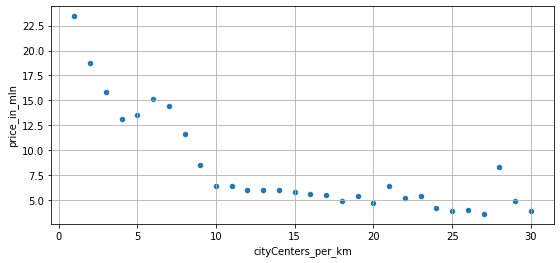

In [ ]:
cityCenters_pivot.plot(kind='scatter',x='cityCenters_per_km',y='price_in_mln', grid=True)

Таким образом, мы видим, что цена недвижимости имеет отрицательную зависимость от удаленности к центру города. Чем ближе к центру, тем дороже недвижимость.

### Общий вывод

* Большая часть недвижимости стоит от 4 до 6 млн руб (это приблизительно 50% значений)
* Большее число объявлений было выставлено с февраля по апрель, а также в ноябре
* Наиболее популярный день недели выставления объявлений - будние дни
* С каждым годом объявлений все больше и больше, в 2019 году небольшое значение, так как скорее всего этот год еще не закончился
* Центр города находится на растоянии в основном до 20 км
* Среднее количество дней продажи квартир - 180. Быстрые продажи - до 45 дней, долгие - 200 дней.
Максимальное значение достигло 4 лет.
Минимальное - 1 день
* Чем больше площадь недвижимости, тем больше стоимость, жилая площадь и площадь кухни имеют среднее положительное влияние на стоимость.
* Из 10 населенных пунктов с самым большим числом объявлений наибольшая средняя цена за м2 в Санкт-Петербурге (114 764.28 руб.), а самая наименьшая в Выборге (58 141.91 руб.). А если рассматривать все данные - наибольшая цена за м2 в посёлке Лисий Нос (121 616.22 руб.), а наименьшая в деревне Старополье (11 206.22 руб.)
* По году выставления объявления видно, что их количество растет с каждым годом, при этом увеличивается и максимальная цена недвижимости. В 2019 году значений не так много, так как год в момент исследования еще не закончился, однако наблюдается положительная тенденция роста цен. 
* С 2014 года среднее и медианное значение цены за год снижалось, однако в 2019 наблюдается подъем, но мы не можем брать это значение в рассчет, так как год еще не закончен. В 2017 году виден пик максимальной цены, после чего она пошла на спад, минимальная цена достигла своего пика в 2014 году, после чего также пошла на спад
* Цена недвижимости имеет отрицательную зависимость от удаленности к центру города. Чем ближе к центру, тем дороже недвижимость.



Таким образом, основными факторами, влияющими на цену недвижимости, являются - ее общая площадь и удаленность от центра города